In [1]:
import os
import time
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import onnx
import onnxruntime

from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
from torchvision import transforms
from matplotlib import pyplot as plt

# Import modules
from matching import matching
from evaluation.metrics import createPR, recallAt100precision, recallAtK
from datasets.load_dataset import GardensPointDataset, SFUDataset, StLuciaDataset

# conda install pytorch torchvision torchaudio pytorch-cuda=11.8 -c pytorch -c nvidia
# conda install onnx onnxruntime
# pip install torch torchvision numpy opencv-python seaborn matplotlib scikit-learn pillow onnxscript

c:\Users\Irfan Q\miniconda3\envs\bruh\Lib\site-packages\onnxruntime\capi\onnxruntime_validation.py:26: UserWarning: Unsupported Windows version (11). ONNX Runtime supports Windows 10 and above, only.
  warnings.warn(


In [2]:
imgs_db, imgs_q, GThard, GTsoft = GardensPointDataset().load()
# imgs_db, imgs_q, GThard, GTsoft = SFUDataset().load()
# imgs_db, imgs_q, GThard, GTsoft = StLuciaDataset().load()

print(type(imgs_db))
print(type(imgs_q))
print(type(GThard))
print(type(GTsoft))

===== Load dataset GardensPoint day_right--night_right
<class 'list'>
<class 'list'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [3]:
model = torch.hub.load("gmberton/eigenplaces", "get_trained_model", backbone="ResNet50", fc_output_dim=2048)

print(model)

print(dir(model))

Using cache found in C:\Users\Irfan Q/.cache\torch\hub\gmberton_eigenplaces_main


Returning EigenPlaces model with backbone: ResNet50 with features dimension 2048


Using cache found in C:\Users\Irfan Q/.cache\torch\hub\gmberton_cosplace_main


Returning CosPlace model with backbone: ResNet50 with features dimension 512
GeoLocalizationNet_(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [4]:
# # set the model to inference mode
# model.eval()

# example_input = torch.randn(1, 3, 360, 640, requires_grad=True)

# example_output = model(example_input)

# dynamic_axes = {"input": {0: "batch_size"}, "output": {0: "batch_size"}}

# # Export the model
# torch.onnx.export(
#     model,  # model
#     example_input,  # example input
#     "cosplace_model.onnx",  # output file name
#     export_params=True,  # export model parameters
#     input_names=["input"],  # input names
#     output_names=["output"],  # output names
#     dynamic_axes=dynamic_axes,  # dynamic axes
# )

# ort_session = onnxruntime.InferenceSession("eigenplaces_model.onnx")

In [5]:
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [6]:
class CustomImageDataset(Dataset):
    def __init__(self, imgs, transform=None):
        self.imgs = imgs
        self.transform = transform

    def __len__(self):
        return len(self.imgs_db)
    
    def __getitem__(self, idx) :
        img = self.imgs_db[idx]
        img = Image.fromarray(img)

        if self.transform:
            img = self.transform(img)

        return(img)

In [7]:
db_tensor = []

for img in imgs_db:
    img = preprocess(Image.fromarray(img))
    db_tensor.append(img)

# Convert list of tensors to a single tensor
db_tensor = torch.stack(db_tensor, axis=0)

print(db_tensor.shape)

torch.Size([200, 3, 540, 960])


In [8]:
q_tensor = []

for img in imgs_q:
    img = preprocess(Image.fromarray(img))
    q_tensor.append(img)

# Convert list of tensors to a single tensor
q_tensor = torch.stack(q_tensor, axis=0)

print(q_tensor.shape)

torch.Size([200, 3, 360, 640])


In [9]:
db_dataset = CustomImageDataset(imgs_db, transform=preprocess)
q_dataset = CustomImageDataset(imgs_q, transform=preprocess)

batch_size = 32
db_dataloader = DataLoader(db_tensor, batch_size=batch_size, shuffle=False, num_workers=4)
q_dataloader = DataLoader(q_tensor, batch_size=batch_size, shuffle=False, num_workers=4)

# sometimes when more than one worker is used, the data loader might not load contiguously in memory, different orders
# to overcome the issue - return batch of data list of images, indices of the images to verify the order
# write the descriptors 

# ARM CPUs - set number of workers = 0

This cell makes my computer lag

In [10]:
# # Pass database tensor through the model
# db_features = model(db_tensor)
# print(db_features.shape)

# # Pass query tensor through the model
# q_features = model(q_tensor)
# print(q_features.shape)

In [11]:
model.eval()

# Pass database tensor through the model

db_features = []

with torch.no_grad():

    for batch in db_dataloader:
        output = model(batch)
        db_features.append(output)

db_features = torch.cat(db_features, axis=0)

print(db_features.shape)

# Pass query tensor through the model

q_features = []

with torch.no_grad():

    for batch in q_dataloader:
        output = model(batch)
        q_features.append(output)

q_features = torch.cat(q_features, axis=0)

print(q_features.shape)

torch.Size([200, 2048])
torch.Size([200, 2048])


In [12]:
from sklearn.metrics.pairwise import cosine_similarity

db_features_np = db_features.detach().numpy()
q_features_np = q_features.detach().numpy()

# Convert pytorch tensors to numpy arrays
similarity_matrix = cosine_similarity(db_features_np, q_features_np)

print(similarity_matrix.shape)

(200, 200)


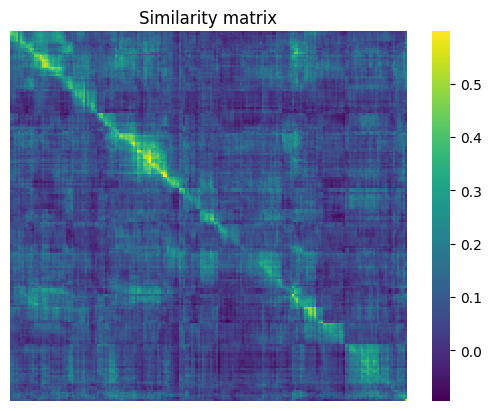

In [13]:
plt.figure()
sns.heatmap(similarity_matrix, cmap='viridis')
plt.title('Similarity matrix')
plt.axis('off')
plt.show()